View this notebook on [nbviewer](https://nbviewer.jupyter.org/urls/gitlab.com/BinCheng/random-quantum-circuit/raw/master/variable_elimination_algorithm.ipynb).

In [1]:
import numpy as np

In [2]:
import qutip as qt

In [3]:
from time import clock

In [2]:
pi = np.pi
e = np.e

In [6]:
x = qt.sigmax()   # Pauli-X matrix

On FIG.6, $\mathtt{arXiv: 1608.00263}$:

2 $\leftrightarrow$ layer 1, 1 $\leftrightarrow$ layer 2, 3 $\leftrightarrow$ layer 6, 4 $\leftrightarrow$ layer 5, 5 $\leftrightarrow$ layer 7, 6 $\leftrightarrow$ layer 8, 7 $\leftrightarrow$ layer 4, 8 $\leftrightarrow$ layer 3.

Below, $[m_1, m_2]$ is the $(m_1n_2 + m_2 + 1)$-th qubit. $m_1$ represents row while $m_2$ represents column.

In [7]:
#%%file random_circuit.py
def Circuit(n1, n2, d):   
    '''
    Create a random circuit with n1 \times n2 qubits and d layers according to sec. IV, [arXiv: 1608.00263].
    The output format is { [gate1, [a1,b1]], [gate2, [a2, b2], [a3, b3]] , ... }, where "gate" is a string, and [ai, bi] is the position 
    indicating which qubit the "gate" is applied to.    
    ''' 
    circuit = {}
    single_gate = ["X_half", "Y_half", "T"]
    
    for m in range(d+1):
        circuit[m] = {} # circuit[0] is the Hadamard layer
        for m1 in range(n1):
            for m2 in range(n2):
                count = m1*n2 + m2   # the count-th qubit
                if m == 0:
                    circuit[m][count] = ["H", [m1, m2]]  # create the Hadamard layer
                    continue
                elif m%8 ==1:  # layer 1
                    if ((m1+1)%2 == 1 and (m2+1)%4 == 1 and (m2+1)!= n2) or ((m1+1)%2 == 0 and (m2+1)%4 == 3 and (m2+1)!= n2):
                        circuit[m][count] = ["CZ", [m1, m2], [m1, m2+1]]
                    elif ((m1+1)%2 == 1 and (m2+1)%4 == 2) or ((m1+1)%2 == 0 and (m2+1)%4 == 0):
                        circuit[m][count] = ["CZT", [m1, m2-1], [m1, m2]]   # "T" for target
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==2:  # layer 2
                    if ((m1+1)%2 == 0 and (m2+1)%4 == 1 and (m2+1)!= n2) or ((m1+1)%2 == 1 and (m2+1)%4 == 3 and (m2+1)!= n2):
                        circuit[m][count] = ["CZ", [m1, m2], [m1, m2+1]]
                    elif ((m1+1)%2 == 0 and (m2+1)%4 == 2) or ((m1+1)%2 == 1 and (m2+1)%4 == 0):
                        circuit[m][count] = ["CZT", [m1, m2-1], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==7:  # layer 7
                    if ((m2+1)%2 == 0 and (m1+1)%4 == 1 and (m1+1)!= n1) or ((m2+1)%2 == 1 and (m1+1)%4 == 3 and (m1+1)!= n1):
                        circuit[m][count] = ["CZ", [m1, m2], [m1+1, m2]]
                    elif ((m2+1)%2 == 0 and (m1+1)%4 == 2) or ((m2+1)%2 == 1 and (m1+1)%4 == 0):
                        circuit[m][count] = ["CZT", [m1-1, m2], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==0 and m != 0:  # layer 8
                    if ((m2+1)%2 == 1 and (m1+1)%4 == 1 and (m1+1)!= n1) or ((m2+1)%2 == 0 and (m1+1)%4 == 3 and (m1+1)!= n1):
                        circuit[m][count] = ["CZ", [m1, m2], [m1+1, m2]]
                    elif ((m2+1)%2 == 1 and (m1+1)%4 == 2) or ((m2+1)%2 == 0 and (m1+1)%4 == 0):
                        circuit[m][count] = ["CZT", [m1-1, m2], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==5:  # layer 5
                    if ((m2+1)%2 == 1 and (m1+1)%4 == 2 and (m1+1)!= n1) or ((m2+1)%2 == 0 and (m1+1)%4 == 0 and (m1+1)!= n1):
                        circuit[m][count] = ["CZ", [m1, m2], [m1+1, m2]]
                    elif ((m2+1)%2 == 1 and (m1+1)%4 == 3) or ((m2+1)%2 == 0 and (m1+1)%4 == 1 and (m1+1)>4):
                        circuit[m][count] = ["CZT", [m1-1, m2], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==6:  # layer 6
                    if ((m2+1)%2 == 0 and (m1+1)%4 == 2 and (m1+1)!= n1) or ((m2+1)%2 == 1 and (m1+1)%4 == 0 and (m1+1)!= n1):
                        circuit[m][count] = ["CZ", [m1, m2], [m1+1, m2]]
                    elif ((m2+1)%2 == 0 and (m1+1)%4 == 3) or ((m2+1)%2 == 1 and (m1+1)%4 == 1 and (m1+1)>4):
                        circuit[m][count] = ["CZT", [m1-1, m2], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==3:  # layer 3
                    if ((m1+1)%2 == 0 and (m2+1)%4 == 2 and (m2+1)!= n2) or ((m1+1)%2 == 1 and (m2+1)%4 == 0 and (m2+1)!= n2):
                        circuit[m][count] = ["CZ", [m1, m2], [m1, m2+1]]
                    elif ((m1+1)%2 == 0 and (m2+1)%4 == 3) or ((m1+1)%2 == 1 and (m2+1)%4 == 1 and (m2+1)>4):
                        circuit[m][count] = ["CZT", [m1, m2-1], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
                elif m%8 ==4:  # layer 4
                    if ((m1+1)%2 == 1 and (m2+1)%4 == 2 and (m2+1)!= n2) or ((m1+1)%2 == 0 and (m2+1)%4 == 0 and (m2+1)!= n2):
                        circuit[m][count] = ["CZ", [m1, m2], [m1, m2+1]]
                    elif ((m1+1)%2 == 1 and (m2+1)%4 == 3) or ((m1+1)%2 == 0 and (m2+1)%4 == 1 and (m2+1)>4):
                        circuit[m][count] = ["CZT", [m1, m2-1], [m1, m2]]
                    else:
                        circuit[m][count] = [np.random.choice(single_gate,1)[0], [m1, m2]]
    
    return circuit

In [8]:
def Gate(gate, b1, b2):   
    '''
    Given a gate and variables, output the corresponding factor. For example, Gate("CZ", 0, 0) = 1 and Gate("H", 1, 1) = -1/sqrt(2).
    '''
    if gate == "CZ":
        if b1 == b2 == 1:
            return -1
        else:
            return 1
    else:   
        up = qt.basis(2,0)
        b1_ket = x**(b1)*up  # input index
        b2_ket = x**(b2)*up  # output index
        if gate == "H":
            return (b1_ket.dag()*qt.snot()*b2_ket)[0,0]
        elif gate == "X_half":
            return (b1_ket.dag()*qt.rx(pi/2)*b2_ket)[0,0]
        elif gate == "Y_half":
            return (b1_ket.dag()*qt.ry(pi/2)*b2_ket)[0,0]
        elif gate == "T":
            return (b1_ket.dag()*qt.phasegate(pi/4)*b2_ket)[0,0]

In [9]:
def InitialFactors(circuit):
    '''
    Create initial factors according to the circuit.
    The output format is [ temp1, temp2, temp3, ... ], where temp_i is [factor, [j,k], [j', k']] and [j,k] corresponds to b_j^k.
    '''
    factors = []   # used to store all factors: factors = [temp1, temp2, ...] 
    
    for m2 in range(n2):
        for m1 in range(n1):
            for m in range(d+1):
                factor = np.zeros((2,2), dtype=complex)   # used to store a single factor
                temp = []   # used to store a single factor: temp = [factor, index1, index2, ...], 
                            # index is of the form [k,m]                
                k = m1*n2 + m2   # the k-th qubit
                gate = circuit[m][k]
                if gate[0] == "CZT":
                    continue
                    
                for b1 in range(2):
                    for b2 in range(2):
                        factor[b1,b2] = Gate(gate[0],b1,b2)
                temp.append(factor)
                
                count = 0
                try:   # count the number of CZ gates before the current gate                    
                    for m3 in range(m):
                        if circuit[m3][k][0] == "CZ" or circuit[m3][k][0] == "CZT":
                            count += 1
                except Exception:
                    pass
                temp.insert(1, [k,m-count])
                
                
                if gate[0] == "CZ":
                    k1 = n2*gate[2][0] + gate[2][1] 
                    count1 = 0
                    try:
                        for m3 in range(m):
                            if circuit[m3][k1][0] == "CZ" or circuit[m3][k1][0] == "CZT":
                                count1 += 1
                    except Exception:
                        pass
                    temp.insert(1, [k1,m-count1])
                else:
                    temp.insert(1, [k,m+1-count])

                factors.append(temp)
    return factors

In [533]:
a = InitialFactors(circuit)
a

[[array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]), [0, 1], [0, 0]],
 [array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]), [3, 1], [3, 0]],
 [array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]), [1, 1], [1, 0]],
 [array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]), [4, 1], [4, 0]],
 [array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]), [2, 1], [2, 0]],
 [array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]), [5, 1], [5, 0]]]

In [10]:
def Binary2Decimal(binary_list):
    '''Return a decimal number, given an input binary list.'''
    result = 0
    for m in range(len(binary_list)):
        result += 2**m*binary_list[len(binary_list)-m-1]
    return int(result)

In [11]:
def Decimal2Binary(n,l):
    '''Return a binary list of length l, given the decimal number n'''
    result = []
    while n//2 != 0:
        remainder = n%2
        result.insert(0, int(remainder))
        n = (n - remainder)/2
    result.insert(0,int(n))
    while len(result) < l:
        result.insert(0,0)
    return result

In [12]:
def List2ArrayElement(l, a):   
    '''
    Convert a list into an array index, and then return the corresponding value. "l" for list, and "a" for array.
    '''
    b = len(a.shape)      
    d = Binary2Decimal(l)   # convert the list l into a decimal number d
    return a.reshape(2**b)[d]

In [69]:
a = np.arange(8)
#a = a.reshape(2*np.ones(3, dtype=int))
a = a.reshape((2,2,2))
print(a)
List2ArrayElement([0,1,1],a)

[[[0 1]
  [2 3]]

 [[4 5]
  [6 7]]]


3

In [13]:
def Multiplication(fac1, fac2, var1, var2):
    '''
    "var1" in "fac1" and "var2" in "fac2" are the same. Multiply fac1 and fac2 to get a larger factor.
    '''
    fac2.pop(var2+1)   # this pop operation might have problem in case of deep copy
    result = fac1 + fac2
    result.pop(len(fac1))
    size = len(result) - 1   # size of the new factor
    factor = np.zeros(2**size, dtype=complex)
    for m in range(2**size):
        b = Decimal2Binary(m, size)
        b1 = b[: (len(fac1) - 1)]
        b2 = b[(len(fac1)-1): ]
        b2 = np.insert(b2, var2, b1[var1])
        factor[m] = List2ArrayElement(b1, fac1[0])*List2ArrayElement(b2.tolist(), fac2[0])
    a = 2*np.ones(size, dtype=int)
    factor = factor.reshape(a)
    result[0] = factor
    #print(size)
    #print(a)
    return result

In [37]:
List2ArrayElement([1,1,0,1], a2[0])

(-0.24999999916098423-0.24999999916098423j)

In [42]:
a = [np.array([[ 0.5-0.5j,  0.5-0.5j], [ 0.5+0.5j, -0.5-0.5j]]), [1, 1], [0, 2]]
b = [np.array([[ 0.70710678+0.j,  0.70710678+0.j], [ 0.70710678+0.j, -0.70710678+0.j]]), [1, 0], [1, 1]]
c = [np.array([[ 0.70710678+0.j,  0.70710678+0.j], [-0.70710678+0.j,  0.70710678+0.j]]), [1, 1], [1, 2]]
a1 = Multiplication(a,b,0,1)
a2 = Multiplication(a1,c,0,0)
a2

[array([[[[ 0.25-0.25j,  0.25-0.25j],
          [ 0.25-0.25j,  0.25-0.25j]],
 
         [[ 0.25-0.25j,  0.25-0.25j],
          [ 0.25-0.25j,  0.25-0.25j]]],
 
 
        [[[-0.25-0.25j,  0.25+0.25j],
          [ 0.25+0.25j, -0.25-0.25j]],
 
         [[ 0.25+0.25j, -0.25-0.25j],
          [-0.25-0.25j,  0.25+0.25j]]]]), [1, 1], [0, 2], [1, 0], [1, 2]]

In [43]:
VariableEliminationAssign(a2,0,1)

[array([[[-0.25-0.25j,  0.25+0.25j],
         [ 0.25+0.25j, -0.25-0.25j]],
 
        [[ 0.25+0.25j, -0.25-0.25j],
         [-0.25-0.25j,  0.25+0.25j]]]), [0, 2], [1, 0], [1, 2]]

In [14]:
def VariableElimination(fac, var):
    '''
    Eliminate the var-th variable of fac[0] by summing over it. fac is of the form [array, [j,k],[j',k']].
    '''
    size = len(fac)-2   # size of the new factor
    
    factor = np.zeros(2**size, dtype=complex)
    for m in range(2**size):
        for m1 in range(2):
            d = Decimal2Binary(m, size)
            d = np.insert(d, var, m1)
            factor[m] += List2ArrayElement(d.tolist(), fac[0])
    a = 2*np.ones(size, dtype=int)
    factor = factor.reshape(a)
    fac[0] = factor
    fac.pop(var+1)
    return fac

In [374]:
a = [np.array([[[ 0.5+0.j,  0.5+0.j], [ 0.5+0.j,  0.5+0.j]], [[ 0.5-0.j, -0.5+0.j], [-0.5+0.j,  0.5+0.j]]]), [0, 1], [1, 1], [0, 2]]
VariableElimination(a,0)

[array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]), [1, 1], [0, 2]]

In [15]:
def VariableEliminationAssign(fac, var, b):
    '''
    Eliminate the var-th variable of fac[0] by assigning the value b to it. fac is of the form [array, [j,k],[j',k']].
    '''
    size = len(fac)-2   # size of the new factor
    
    factor = np.zeros(2**size, dtype=complex)
    for m in range(2**size):
        d = Decimal2Binary(m, size)
        d = np.insert(d, var, b)
        factor[m] += List2ArrayElement(d.tolist(), fac[0])
    a = 2*np.ones(size, dtype=int)
    factor = factor.reshape(a)
    fac[0] = factor
    fac.pop(var+1)
    return fac

In [16]:
def Merge(fac, var1, var2):
    '''
    Eliminate duplicate variables of a factor.
    '''
    size = len(fac) - 2   # size of the new factor
    
    factor = np.zeros(2**size, dtype=complex)
    for m in range(2**size):
        d = Decimal2Binary(m, size)
        b = d[var1]
        d = np.insert(d, var2, b)
        factor[m] += List2ArrayElement(d.tolist(), fac[0])
    a = 2*np.ones(size, dtype=int)
    factor = factor.reshape(a)
    fac[0] = factor
    fac.pop(var2+1)
    return fac

In [60]:
def VerticleOrdering(circuit, init, final):   
    '''
    Eliminate all variables to simulate a quantum circuit, i.e., return an output amplitude, 
    according to the verticle elimination ordering [arXiv: 1712.05384].
    '''
    # V for verticle ordering
    factors = InitialFactors(circuit)   # used to store all factors: factors = [temp1, temp2, ...], where temp = [factor, [j,k], [j',k'], ...]
    result = 1    
    
    depth = np.zeros(n, dtype=int)
    for m1 in range(len(factors)):
        for m2 in range(len(factors[m1]) - 1):
            index = factors[m1][m2+1]
            if depth[index[0]] < index[1]:
                depth[index[0]] = index[1]   # find the depth of every qubit
    #print(depth)
    
    #print(factors, "\n")
    while len(factors) != 0:
        #print(factors)
        #print(result)
        #print("\n")
        index1 = factors[0][1]   # index1 if [j,k], j-th qubit and k-th timestep

        if index1[1] == 0:
            b1 = init[index1[0]]
            if len(factors[0]) == 2:
                result = result*factors[0][0][b1]
                factors.pop(0)
                continue
            factors[0] = VariableEliminationAssign(factors[0], 0, b1)
            continue
        #print(factors, "\n")
        l = len(factors)-1
        m = 1
        #depth = index1[1]
        while m <= l:
            check = False
            for m1 in range(len(factors[m])-1):                
                if index1 == factors[m][m1+1]:
                    #print("m = ", m, " ,m1 = ", m1)
                    factors[0] = Multiplication(factors[0], factors[m], 0, m1)
                    factors.pop(m)
                    #print(factors, "\n")
                    
                    m2 = 1
                    l2 = len(factors[0]) - 2
                    while m2 < l2:
                        check1 = True
                        index2 = factors[0][m2+1]
                        for m3 in range(l2-m2):
                            index3 = factors[0][l2+1-m3]
                            if index2 == index3:
                                factors[0] = Merge(factors[0], m2, l2-m3)
                                l2 -= 1
                                check1 = False
                                break
                        if check1:
                            m2 += 1
                                
                    l -= 1
                    break
                if m1 == len(factors[m]) - 2:
                    check = True
                #if index1[0] == factors[m][m1+1][0] and depth < factors[m][m1+1][1]:
                #    depth = factors[m][m1+1][1]   # find the depth of the worldline of the current qubit
            if check == True:
                m += 1
        #print("\n", m, l)
        #print("before elimination\n", factors, "\n")
        #for m1 in range(len(factors[0])-1):
        #    if index1[0] == factors[0][m1+1][0] and depth < factors[0][m1+1][1]:
        #        depth = factors[0][m1+1][1]   # find the depth of the worldline of the current qubit
        
        #print("qubit:", index1[0], ", depth:", depth)
        if depth[index1[0]] == index1[1]:
            #print(index1)
            b2 = final[index1[0]]
            if len(factors[0]) == 2:
                result = result*factors[0][0][b2]
                factors.pop(0)
            else:
                factors[0] = VariableEliminationAssign(factors[0], 0, b2)
                #factors[0][0] = factors[0][0][b2]
                #(factors[0]).pop(1)
        else:
            if len(factors[0]) == 2:
                result = result*(factors[0][0][0] + factors[0][0][1])
                factors.pop(0)
            else:
                factors[0] = VariableElimination(factors[0], 0)
        #print(factors, "\n")
    return result

In [69]:
%%time
VerticleOrdering(circuit, init, final)

Wall time: 1.67 s


(0.05334708691207983+2.0816681711721685e-17j)

## Verification

In [66]:
n1 = 1
n2 = 10
n = n1*n2
d = 11

In [67]:
circuit = Circuit(n1,n2,d)
#circuit

In [ ]:
circuit

In [34]:
init = np.random.choice(1,n) # initial state
final = np.random.choice(2,n) # intended output state

In [35]:
print(init,final)

[0 0 0 0 0 0 0 0 0 0] [0 1 0 0 1 0 1 0 1 0]


In [36]:
# generate initial state and final state
up = qt.basis(2,0) # |0>
for m in range(n):
    if m == 0:
        initQ = x**(init[m])*up
        finalq = x**(final[m])*up
        continue
    initQ = qt.tensor(initQ, x**(init[m])*up)
    finalq = qt.tensor(finalq, x**(final[m])*up)

In [68]:
%%time

finalQ = initQ

for m in circuit:
    for key in circuit[m]:
        if circuit[m][key][0] == "H":
            a = n2*circuit[m][key][1][0] + circuit[m][key][1][1] # m1*n2+m2
            finalQ = qt.snot(n, a)*finalQ
        elif circuit[m][key][0] == "X_half":
            a = n2*circuit[m][key][1][0] + circuit[m][key][1][1] # m1*n2+m2
            finalQ = qt.rx(pi/2, n, a)*finalQ
        elif circuit[m][key][0] == "Y_half":
            a = n2*circuit[m][key][1][0] + circuit[m][key][1][1] # m1*n2+m2
            finalQ = qt.ry(pi/2, n, a)*finalQ
        elif circuit[m][key][0] == "T":
            a = n2*circuit[m][key][1][0] + circuit[m][key][1][1] # m1*n2+m2
            finalQ = qt.phasegate(pi/4, n, a)*finalQ
        elif circuit[m][key][0] == "CZ":
            a = n2*circuit[m][key][1][0] + circuit[m][key][1][1]
            b = n2*circuit[m][key][2][0] + circuit[m][key][2][1]
            finalQ = qt.csign(n, a, b)*finalQ
print((finalq.dag()*finalQ)[0,0])

(0.05334708691207977+0j)
Wall time: 147 ms


In [ ]:
finalQ

In [75]:
for m in range(2**n):
    final = Decimal2Binary(m,n)
    final = np.array(final)
    prob1 = finalQ[m][0][0]
    prob2 = VerticleOrdering(circuit, init, final)
    if np.isclose(prob1, prob2):
        pass
    else:
        print(final, prob1, prob2)
    if m > 100:
        break

In [711]:
%%time
count = 0
for m in range(2**n):
    if finalQ[m][0][0] != 0:
        count += 1
print(count)

64
Wall time: 17 ms


In [474]:
for m in range(2**n):
    final = Decimal2Binary(m,n)
    final = np.array(final)
    print(VerticleOrdering(circuit, init, final))

(-0.25000000000000006+0.10355339059327379j)
0j
(-0.6035533905932741-0.25000000000000017j)
0j
(0.6035533905932741+0.25000000000000017j)
0j
(0.10355339059327379+0.25000000000000006j)
(-6.245004513516506e-17+0j)


## Plot figure

In [4]:
from matplotlib import *
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
from matplotlib.ticker import MaxNLocator # display integers in the x/y axis

In [7]:
from matplotlib.backends.backend_pdf import PdfPages

In [8]:
depth = np.arange(20) + 1
depth

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [9]:
# runtime of variable elimination algorithm for 3 × 2 qubit, 20 datas
VE_3_2 = [0.03386, 0.045099, 0.0695, 0.1137, 0.1458, 0.1676, 0.1923, \
         0.2289, 0.2964, 0.3712, 0.5588, 0.9530, 1.8538, 4.8587, \
         15.677, 21.398, 23.189, 23.387, 23.9929, 23.7896]

In [10]:
# runtime of variable elimination algorithm for 3 × 3 qubit, only 17 datas
VE_3_3 = [0.0493, 0.07725, 0.1175, 0.1607, 0.2097, 0.2597, 0.4028, \
         0.9462, 1.5295, 3.1971, 8.2659, 30.340, 108.28, 310.936, \
         777.144, 839.176, 2060.888]

In [11]:
# runtime of variable elimination algorithm for 3 × 4 qubit, only 13 datas
VE_3_4 = [0.067055, 0.101226, 0.13858, 0.19715, 0.2522, 0.3968, 0.68212, 17.312, \
         18.1135, 60.6478, 105.463, 421.301, 1784.315]

In [12]:
# runtime of variable elimination algorithm for 3 × 5 qubit, only 12 datas
VE_3_5 = [0.08280, 0.1330, 0.18905, 0.2513, 0.3168, 0.7284, 1.588, 38.3058, 78.983, 260.415, 478.98, 1769.05]

In [13]:
# runtime of variable elimination algorithm for 4 × 5 qubit, only 11 datas
VE_4_5 = [0.11496, 0.1828, 0.2506, 0.3348, 0.42397, 0.88422, 1.8685, 48.163, 336, 1324, 2867]

In [16]:
# runtime of state evolution algorithm for 4 × 5 qubit, 20 datas
SE_4_5 = [6.755, 10.38, 14.18, 18.23, 21.27, 25.06, 29.098, 32.42, 38.21, 41.10, 44.022, 48.414, \
         52.539, 57.99, 62.20, 66.144, 72.465, 70.36, 74.92, 76.426]

In [31]:
# runtime of variable elimination algorithm for 5 × 5 qubit, only 9 datas
VE_5_5 = [0.13915, 0.22508, 0.315, 0.412, 0.5155, 1.160, 2.76, 321.57, 1001,]

In [36]:
# runtime of state evolution algorithm for 5 × 5 qubit, only 6 datas
SE_5_5 = [333, 504, 699, 878.92, 1081, 1249]

In [32]:
pp = PdfPages('images/variable_elimination.pdf')
fig, ax = plt.subplots()
ax.plot(depth, VE_3_2,"g*-",label=r"3 $\times$ 2")
ax.plot(depth[:17], VE_3_3,"g*-",label=r"3 $\times$ 3",color="blue")
ax.plot(depth[:13], VE_3_4,"g*-",label=r"3 $\times$ 4", color = "purple")
ax.plot(depth[:12], VE_3_5,"g*-",label=r"3 $\times$ 5", color = "red")
ax.plot(depth[:11], VE_4_5,"g*-",label=r"4 $\times$ 5", color = "yellow")
ax.plot(depth[:9], VE_5_5,"g*-",label=r"5 $\times$ 5", color = "orange")
ax.legend(loc=0)
ax.set_xlabel('number of qubits')
ax.set_ylabel('runtime/s')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
pp.savefig(fig)
pp.close()

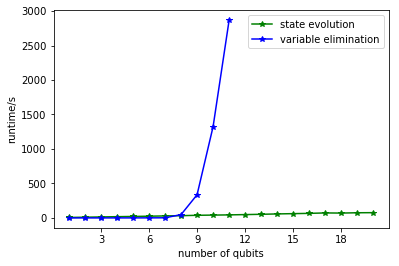

In [20]:
pp = PdfPages('images/VE_SE_4_5.pdf')
fig, ax = plt.subplots()
ax.plot(depth, SE_4_5,"g*-",label=r"state evolution")
ax.plot(depth[:11], VE_4_5,"g*-",label=r"variable elimination", color = "blue")
ax.legend(loc=0)
ax.set_xlabel('number of qubits')
ax.set_ylabel('runtime/s')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
pp.savefig(fig)
pp.close()

In [37]:
pp = PdfPages('images/VE_SE_5_5.pdf')
fig, ax = plt.subplots()
ax.plot(depth[:6], SE_5_5,"g*-",label=r"state evolution")
ax.plot(depth[:9], VE_5_5,"g*-",label=r"variable elimination", color = "blue")
ax.legend(loc=0)
ax.set_xlabel('number of qubits')
ax.set_ylabel('runtime/s')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
pp.savefig(fig)
pp.close()

$$
\begin{align}
\langle y | C | 000 \rangle &= \sum_{x_1, x_2} \langle y |(YXH)| x_2 \rangle \langle x_2 | (CZ\otimes Z) |x_1\rangle\langle x_1| H\otimes CNOT | 000 \rangle \\
&= \sum_{\{b_j^k\}} \ldots \langle b_1^2 b_2^2 | CZ |b_1^1 b_2^1\rangle \langle b_3^2 | Z |b_3^1\rangle \ldots \\
&= \sum_{\{b_j^k\}} \ldots CZ_{b_1^2 b_2^2,\ b_1^1 b_2^1} \ \ Z_{b_3^2,\ b_3^1} \ldots
\end{align}
$$